### Introduction
This code walks through the process of post-processing and analyzing the coefficient of lift from cylinder flow simulations.

The coefficient of lift of a two-dimensional body is defined as:
$$ C_l(t) = \frac{2l}{\rho u^2 L}, $$

where $l$ is the two-dimensiona lift force, $\rho$ is the fluid density, $u$ is the fluid velocity, and $L$ is a reference length.



In [1]:
###  Import modules

import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import json

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


###  Load the analysis settings and parameters

#  Load the configuration file with all settings
with open('Lift-config.json', 'r') as f:
    config = json.load(f)

#  Read out and import all variables
for key, value in config.items():  print(f"{key}: {value}")
globals().update(config)



Re: 50
t_trm_1: 25000
t_trm_2: 50000
TDE_or_ddt: ddt
TD_Embed: 2
threshold: 0
diff_order: 2
poly_order: 3
should_normalize: 1


In [2]:
%%javascript
require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {}

<IPython.core.display.Javascript object>

# The coefficients of lift and drag
The simulations begin with an initial condition of a zero flowfield every. As the flow is developing, the coefficients of lift and drag being to oscillate and undergo a period of transient growth before saturating onto a final periodic behavior.



In [3]:
###  Load data

from LoadData_lift import fnc_LoadData_lift
t , C_l , C_d , dt = fnc_LoadData_lift( Re , t_trm_1 , t_trm_2 )



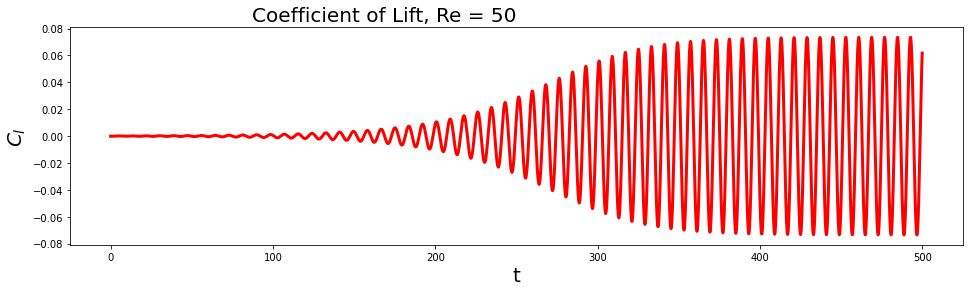

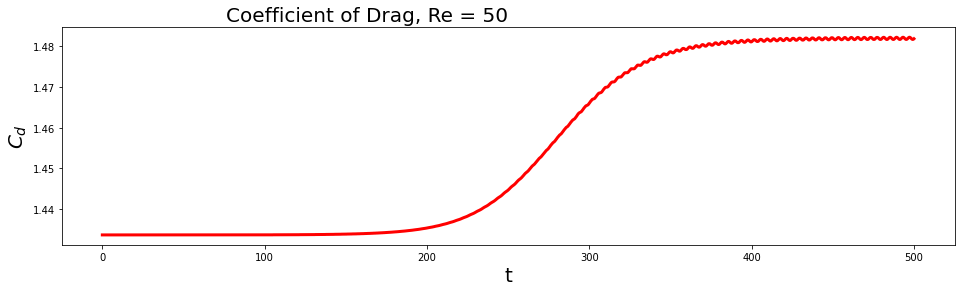

In [4]:
###  Lift

plt.figure(figsize=(16, 4))
plt.plot(t, C_l,  linewidth=3, color='r')
plt.xlabel('t', fontsize=20)
plt.ylabel('$C_l$', fontsize=20)
ttl_str = 'Coefficient of Lift, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20, horizontalalignment='right')
plt.show()


###  Drag

plt.figure(figsize=(16, 4))
plt.plot(t, C_d,  linewidth=3, color='r')
plt.xlabel('t', fontsize=20)
plt.ylabel('$C_d$', fontsize=20)
ttl_str = 'Coefficient of Drag, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20, horizontalalignment='right')
plt.show()



# Raising the dimension of the system
We raise the dimension of the system by either time-delay embedding or time-differentiating.

We plot the system below.



In [10]:
###  Raise dimension of system by either time-delay embedding or time-differentiating

from raiseDim_lift import fnc_raiseDim_lift
t_PS , zeta , eta = fnc_raiseDim_lift( TDE_or_ddt , t , TD_Embed, C_l , should_normalize)



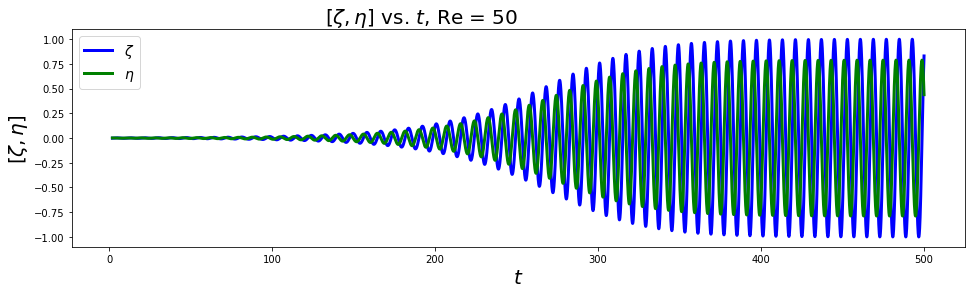

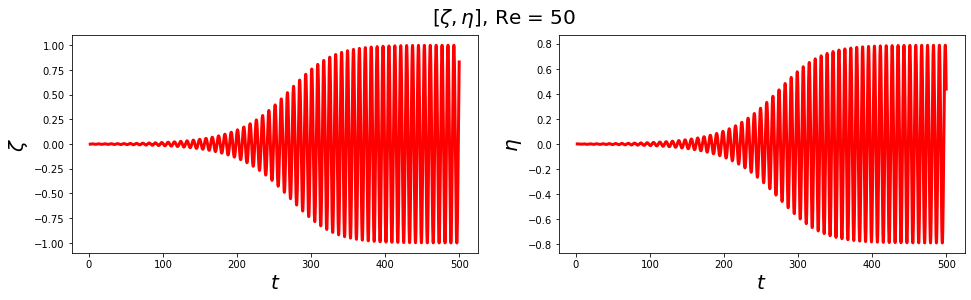

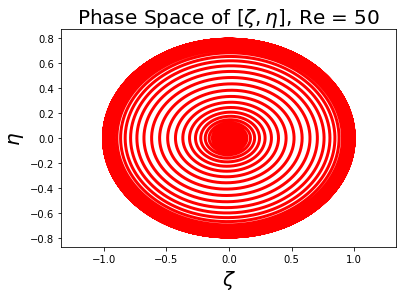

In [12]:
###  Both on same plot

plt.figure(figsize=(16, 4))
plt.plot(t_PS, zeta ,  linewidth=3, color='b' , label='$\zeta$' ) # 
plt.plot(t_PS, eta  ,  linewidth=3, color='g' , label='$\eta$' ) # 
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$[\zeta, \eta]$', fontsize=20)
ttl_str = '$[\zeta, \eta]$ vs. $t$, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20, horizontalalignment='right')
plt.legend(fontsize=14)
plt.show()


# Each on separate plots 

plt.figure(figsize=(16, 4))
ttl_str = r'$[\zeta, \eta]$, Re = ' + str(Re)
plt.suptitle(ttl_str, fontsize=20, horizontalalignment='center')

plt.subplot(1, 2, 1)
plt.plot(t_PS, zeta,  linewidth=3, color='r') # 
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$\zeta$', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(t_PS, eta,  linewidth=3, color='r') # 
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$\eta$', fontsize=20)

plt.show()


# Phase space

plt.figure()
plt.plot(zeta, eta,  linewidth=3, color='r') # 
plt.xlabel('$\zeta$', fontsize=20)
plt.ylabel('$\eta$', fontsize=20)
ttl_str = 'Phase Space of $[\zeta, \eta]$, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.axis('equal')
plt.show()



In [13]:
###  Compare amplitudes of the two signals

# print('')
# print('Max of zeta = ' + str(np.max(zeta)) )
# print('Max of eta  = ' + str(np.max(eta)) )
# print('\n')


# peak_guess_range_finder = int(TD_Embed/dt * 4)
# np.max( zeta[-peak_guess_range_finder:-1]  )
# np.argmax( zeta[-peak_guess_range_finder : -1 ]  )
# np.max( eta[-peak_guess_range_finder:-1]  )
# np.argmax( eta[-peak_guess_range_finder : -1 ]  )



# SINDy
Next, we run the SINDy algorithm on the system $\mathcal{U} = [\zeta, \eta]$. We seek a system of ODEs to model $\mathcal{U}_t = [\zeta_t, \eta_t]$. We fit an ODE with terms from the following library:

$$ \Theta = [ \; \zeta, \eta, \zeta^2, \zeta \eta, \eta^2, \zeta^3, \zeta^2\eta, \zeta \eta^2, \eta^3 \; ] $$



In [14]:
###  Initiate and run SINDy


# fnc_runSINDy():
zeta_dt = ps.FiniteDifference(axis=0)._differentiate(zeta  , dt)
eta_dt  = ps.FiniteDifference(axis=0)._differentiate(eta   , dt)
# return zeta_t , eta_t

X = np.asarray([zeta, eta]).T
feature_names = ["x", "y"]

model = ps.SINDy(
    differentiation_method = ps.FiniteDifference(order   = diff_order ) ,
    feature_library        = ps.PolynomialLibrary(degree = poly_order ) , 
    optimizer              = ps.STLSQ(threshold=threshold),
    feature_names          = feature_names,)


###  Generate SINDy fit

model.fit(X, t=t_PS)

print('')
print('x = zeta')
print('y = eta')
print('\n')
model.print(precision=4)
print('\n')
model.print(precision=10)
print('\n')




X0 = X[0,:]
x_test_sim = model.simulate(X0, t_PS)
error_1 = zeta - x_test_sim[:,0]
error_2 = eta  - x_test_sim[:,1]

NRMSE_1 = np.sqrt( np.sum(error_1**2) / np.sum(zeta**2) )
NRMSE_2 = np.sqrt( np.sum(error_2**2) / np.sum(eta **2) )

NRMSE_sys = np.sqrt( NRMSE_1**2 + NRMSE_2**2 )




x = zeta
y = eta


(x)' = 1.0000 y
(y)' = -0.5570 x + 0.0408 y + -0.0661 x^3 + -0.0412 x^2 y + -0.1050 x y^2 + -0.0659 y^3


(x)' = 1.0000000000 y
(y)' = 0.0000038934 1 + -0.5569915997 x + 0.0408302204 y + -0.0000052798 x^2 + 0.0000159028 x y + 0.0000076406 y^2 + -0.0660738337 x^3 + -0.0411646863 x^2 y + -0.1050349099 x y^2 + -0.0658759863 y^3




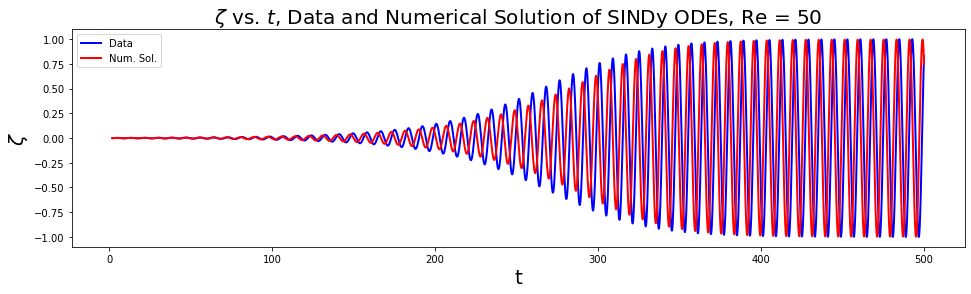

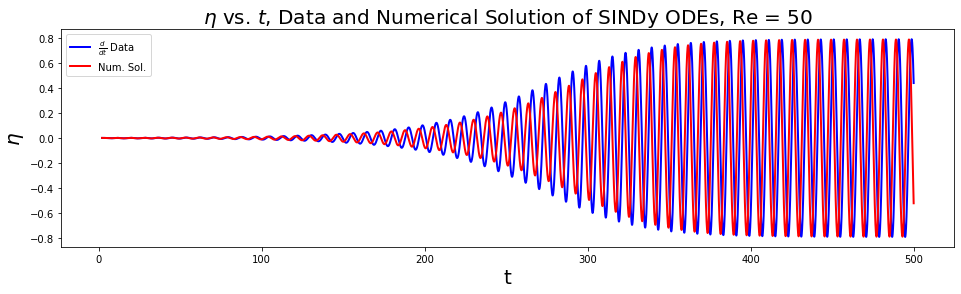

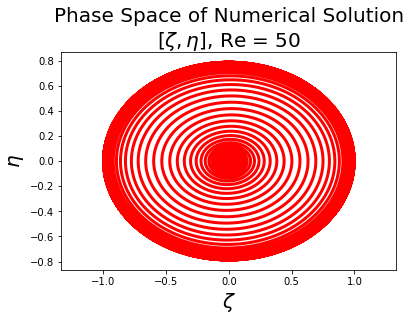

In [15]:
###  Plot the data and the numerical solution of the SINDy ODEs

plt.figure(figsize=(16, 4))
plt.plot(t_PS, zeta,  linewidth=2, color='b', label='Data') # 
plt.plot(t_PS, x_test_sim[:,0],  linewidth=2, color='r', label='Num. Sol.') # 
plt.xlabel('t', fontsize=20)
plt.ylabel('$\zeta$', fontsize=20)
ttl_str = '$\zeta$ vs. $t$, Data and Numerical Solution of SINDy ODEs, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(t_PS, eta,  linewidth=2, color='b', label=r'$\frac{d}{dt}$ Data') # 
plt.plot(t_PS, x_test_sim[:,1],  linewidth=2, color='r', label='Num. Sol.') # 
plt.xlabel('t', fontsize=20)
plt.ylabel('$\eta$', fontsize=20)
ttl_str = '$\eta$ vs. $t$, Data and Numerical Solution of SINDy ODEs, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.legend()
plt.show()


###  Phase space

plt.figure()
plt.plot(x_test_sim[:,0], x_test_sim[:,1],  linewidth=3, color='r') # 
plt.xlabel('$\zeta$', fontsize=20)
plt.ylabel('$\eta$', fontsize=20)
ttl_str = 'Phase Space of Numerical Solution\n'+'$[\zeta,\eta]$, Re = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.axis('equal')
plt.show()



# Compute errors and normalized root-mean-square error (NRMSE)
The _normalized root mean square error_ is a measure of the error between the data and the numerical solution of its SINDy ODE. First we construct the error vector for each signal within $\mathcal{U}$:
$$ \epsilon_i = \mathcal{U}_i - \mathcal{U}^{*}_i .$$

Then we compute the square root of the sum of the errors, and normalize by the square root of the sum of the data.

$$ \text{NRMSE}_i = \sqrt{ \frac{ \sum_{t} \epsilon_i^2 }{ \sum_{t} \mathcal{U}_i^2 } } .$$

Finally, we could compute the NRMSE of the system by computing the $l_2$ norm of the NRMSEs of each signal.

$$ \text{NRMSE}_{sys} = \sqrt{ \text{NRMSE}_1^2 + \text{NRMSE}_2^2 } $$


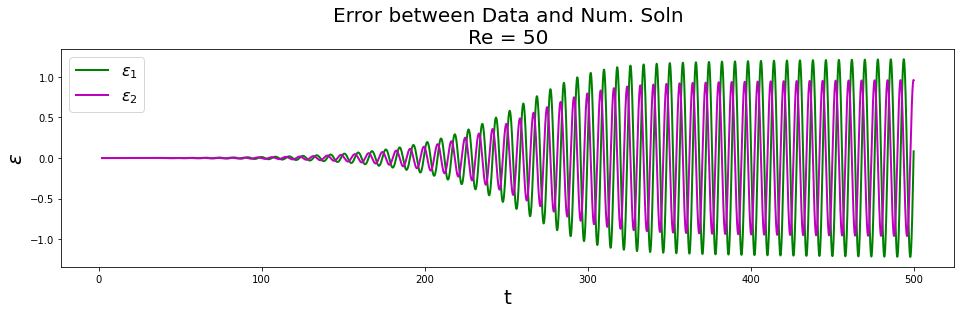



The error between the coefficient of lift system and the numerical solutions of their SINDy ODEs:

Max error on zeta = 1.2173051537716133
Max error on eta  = 0.9614348721524968


NRMSE on zeta = 1.251320870477375
NRMSE on eta  = 1.244624413452572




NRMSE of the system is:

NRMSE_sys = 1.7649061877205865




In [16]:
###  Plot error

plt.figure(figsize=(16, 4))
plt.plot(t_PS, error_1,  linewidth=2, color='g', label=r'$\epsilon_1$') # 
plt.plot(t_PS, error_2,  linewidth=2, color='m', label=r'$\epsilon_2$') # 
plt.xlabel('t', fontsize=20)
plt.ylabel('$\epsilon$', fontsize=20)
ttl_str = 'Error between Data and Num. Soln' + '\nRe = ' + str(Re)
plt.title(ttl_str, fontsize=20)
plt.legend(loc='upper left', fontsize=16)
plt.show()


print('\n\nThe error between the coefficient of lift system and the numerical solutions of their SINDy ODEs:\n')
print('Max error on zeta = ' + str(np.max(error_1)))
print('Max error on eta  = ' + str(np.max(error_2)))
print('\n')
print('NRMSE on zeta = ' + str(NRMSE_1))
print('NRMSE on eta  = ' + str(NRMSE_2))
print('\n')

print('\n')
print('NRMSE of the system is:\n')
print('NRMSE_sys = '+ str(NRMSE_sys) )
print('\n')

